## **Predicting Apartment Prices in Mexico City**

**Task:** 
Write a `wrangle` function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.
3. Create separate `"lat"` and `"lon"` columns.
4. Mexico City is divided into [15 boroughs]. Create a `"borough"` feature from the `"place_with_parent_names"` column.
5. Drop columns that are more than 50\% null values.
6. Drop columns containing low- or high-cardinality categorical values. 
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.
8. Drop any columns that would create issues of multicollinearity. 

#

### Import libraries

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from glob import glob

from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import plotly.express as px


## **1. Prepare Data**

####  Import Data

#### `wrangle function`

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
   
    # Subset data: Apartments in "Capital Federal", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    
    
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    # Split "lat-lon" column and replace, add "lat" and "lon" columns
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    
     # drop "lat-lon" column
    df.drop(columns = "lat-lon", inplace = True)
    
     # Create borough feature
    df['borough'] = df['place_with_parent_names'].str.split("|", expand=True)[1]
    df.drop(columns='place_with_parent_names', inplace=True)    
    
    # drop features with high null count
    df.drop(columns = ["surface_total_in_m2", "floor", "rooms", "expenses"], inplace = True)
    
    
    
    # drop columns with high or low cardinality
    df.drop(columns = ["operation", "property_type",
                       "currency", "properati_url"], inplace = True)
   
    # Drop leaky columns
    df.drop(columns = [
    'price',
    'price_aprox_local_currency',
    'price_per_m2',
    'price_usd_per_m2'],
            inplace = True)
    
    return df

In [3]:
df = wrangle("data/mexico-city-real-estate-1.csv")
print(df.shape)
df.head()

(1101, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


1.1.2 Create the list `files`. 
It should contain the filenames of all the Mexico City real estate CSVs.

In [4]:
files = glob("data/mexico-city-real-estate-*.csv")
files

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv']

**Task 2.5.3:** Combine your `wrangle` function, a list comprehension, and `pd.concat` to create a DataFrame `df`. It should contain all the properties from the five CSVs in `files`. 

In [5]:
frames = [wrangle(file) for file in files]

In [6]:
frames[0].head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [7]:
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3301 entries, 0 to 3300
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        3301 non-null   float64
 1   surface_covered_in_m2  3301 non-null   float64
 2   lat                    3111 non-null   float64
 3   lon                    3111 non-null   float64
 4   borough                3301 non-null   object 
dtypes: float64(4), object(1)
memory usage: 129.1+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


## **2. Explore**

**Task 2.5.4:** Create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Be sure to label the x-axis `"Price [$]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`. Use Matplotlib (`plt`).

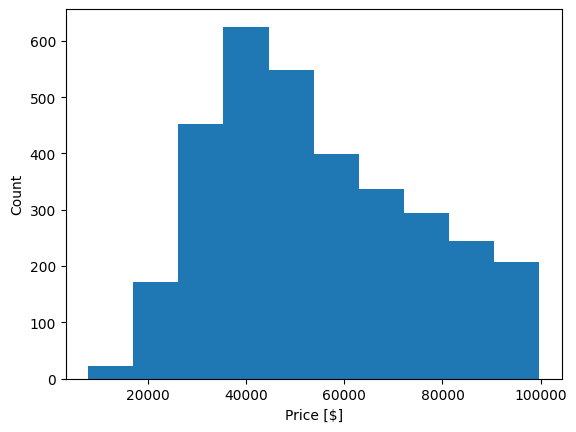

In [8]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("");


**Task 2.5.5:** Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Be sure to label your x-axis `"Area [sq meters]"` and y-axis `"Price [USD]"`. Your plot should have the title `"Mexico City: Price vs. Area"`. Use Matplotlib (`plt`).

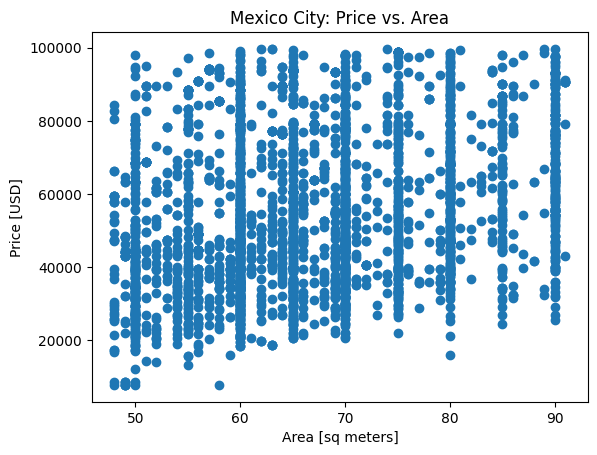

In [9]:
# Build scatter plot
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area");


## **3. Split**

**Task 2.5.7:** Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

In [10]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
y_train = df[target]
X_train = df[features]

## **4. Build Model**

#### Baseline

**Task 2.5.8:** Calculate the baseline mean absolute error for your model.

In [11]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54269.44916388973
Baseline MAE: 17477.509288511163


#### Iterate

**Task 2.5.9:** Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

In [12]:
# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(), 
    Ridge()
)
# Fit model
model.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

#### Evaluate

**Task 2.5.10:** Read the CSV file `mexico-city-test-features.csv` into the DataFrame `X_test`.

In [13]:
X_test = df[features]
X_test.head()

,surface_covered_in_m2,lat,lon,borough
0,57.0,23.634501,-102.552788,Benito Juárez
1,56.0,19.402413,-99.095391,Iztacalco
2,80.0,19.357820,-99.149406,Benito Juárez
3,60.0,19.504985,-99.208557,Azcapotzalco
4,50.0,19.354219,-99.126244,Coyoacán


**Task 2.5.11:** Use your model to generate a Series of predictions for `X_test`. When you submit your predictions to the grader, it will calculate the mean absolute error for your model.

In [14]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    74315.238173
1    50568.508832
2    70992.757460
3    52672.314078
4    50294.772458
dtype: float64

## **4. Communicate Results**

**Task 2.5.12:** Create a Series named `feat_imp`. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.  

In [15]:
coefficients = model.named_steps["ridge"].coef_
feature_names = model.named_steps["onehotencoder"].get_feature_names()

feat_imp = pd.Series(coefficients, index = feature_names).sort_values(key=abs)
feat_imp.head()

borough_Cuauhtémoc        -32.805411
surface_covered_in_m2     305.549139
lat                       630.901585
borough_Iztacalco        1056.723992
borough_Azcapotzalco     1619.183859
dtype: float64

**Task 2.5.13:** Create a horizontal bar chart that shows the **10 most influential** coefficients for your model. Be sure to label your x- and y-axis `"Importance [USD]"` and `"Feature"`, respectively, and give your chart the title `"Feature Importances for Apartment Price"`. Use pandas. 

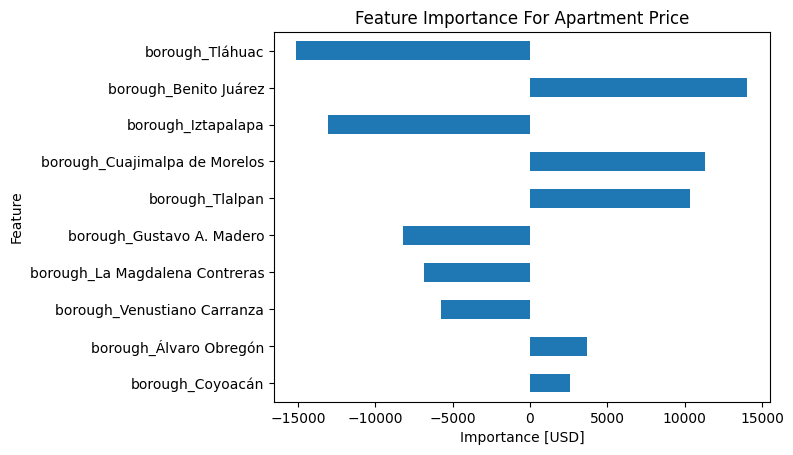

In [16]:
# Build bar chart
feat_imp.sort_values(key = abs).tail(10).plot(kind = "barh")


# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importance For Apartment Price");

